* créer une fonction pour concat les modèles transfer + 1 pour créer le top OK
* FIT les générateurs
* calcul de la batch size

In [6]:
# import plotly
import pandas as pd
import numpy as np
import tensorboard
from mat4py import loadmat
from IPython.display import Image
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img
import keras_tuner as kt
import matplotlib.pyplot as plt


In [2]:
# Clear any logs from previous runs
! rm -rf cnn_log
! rm -rf vgg_log
! rm -rf inception_log
! rm -rf untitled_project
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Load meta data

In [3]:
# Load meta data
train_df = pd.DataFrame(loadmat('./data/lists/train_list.mat'))
test_df = pd.DataFrame(loadmat('./data/lists/test_list.mat'))
train_df.shape, test_df.shape

((12000, 3), (8580, 3))

In [4]:
# Clean dataframe
train_df = train_df.applymap(lambda x: x[0])
test_df = test_df.applymap(lambda x: x[0])
train_df.head()

,file_list,annotation_list,labels
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua/n02085620_5927,1
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua/n02085620_4441,1
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua/n02085620_1502,1
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua/n02085620_1916,1
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua/n02085620_13151,1


# Filter data

In [5]:
# Extract first n labels
N_CLASSES = 3
train_df = train_df[train_df['labels'] <= N_CLASSES]
test_df = test_df[test_df['labels'] <= N_CLASSES]
train_df.shape, test_df.shape

((300, 3), (289, 3))

# Explore data

In [6]:
# Showi number of samples per labels
train_df['labels'].value_counts()

1    100
2    100
3    100
Name: labels, dtype: int64

In [7]:
test_df['labels'].value_counts()

3    152
2     85
1     52
Name: labels, dtype: int64

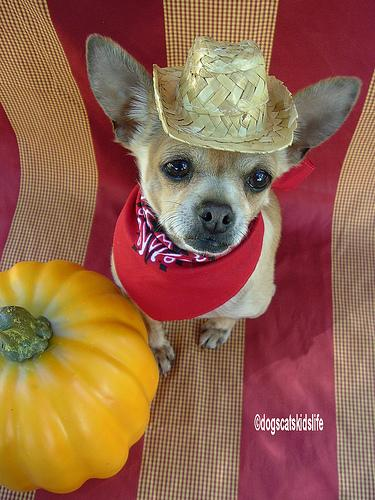

In [8]:
images_path = './data/Images/'

# Show a random picture
sample = train_df.sample(1)
sample_path = images_path + sample['file_list'].values[0]
Image(filename=sample_path)

# Processing and augmentation

In [9]:
def show_transformations(sample_path, datagen_settings, n_examples=3):

    sim_generator = ImageDataGenerator(**datagen_settings)

    img = load_img(sample_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    fig = plt.figure(figsize=(25,25))
    plt.subplot(1,4,1)
    plt.title('Original')
    plt.imshow(img)
    plt.axis('off')

    sim_generator.fit(x)
    
    i = 0
    for img in sim_generator.flow(x, batch_size=1):
        plt.subplot(1,4,i+2)
        plt.title(f'Augmented')
        plt.imshow(img[0])
        plt.axis('off')
        i += 1
        if i == n_examples :
            break

Shape

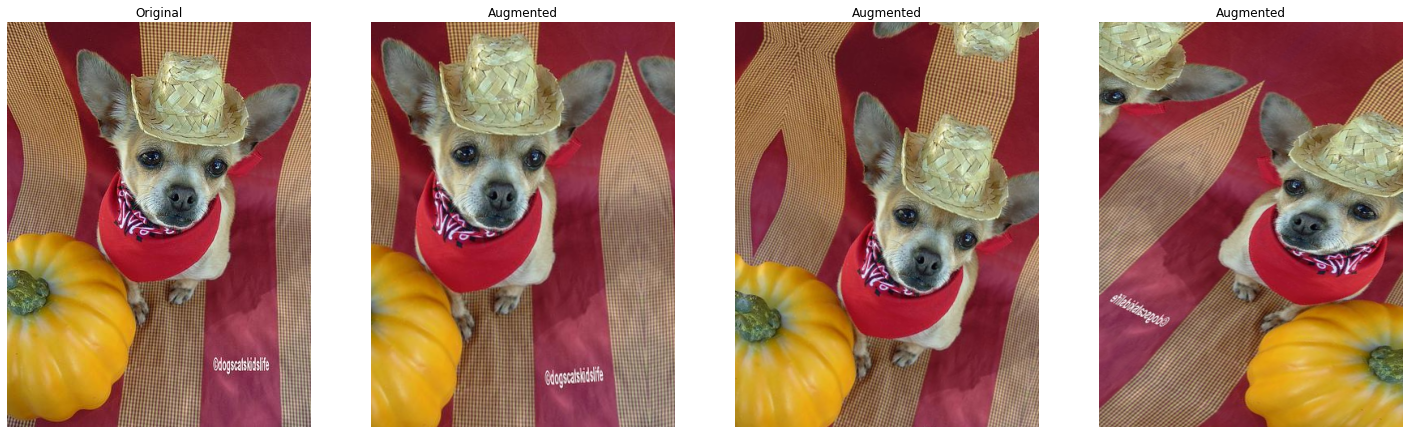

In [10]:
show_transformations(
    sample_path=sample_path,
    datagen_settings=dict(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect'))

Equalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


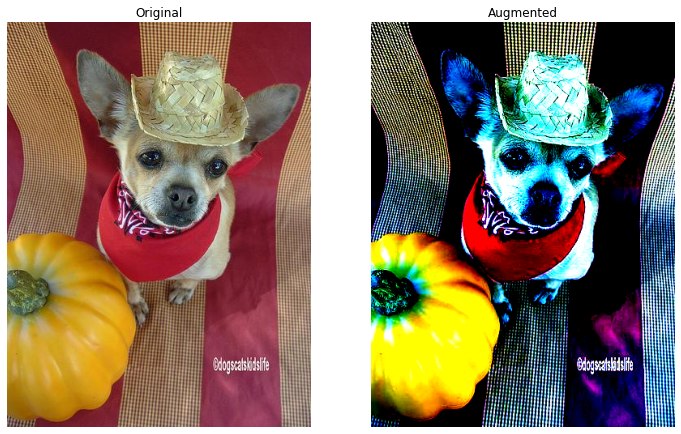

In [11]:
show_transformations(
    sample_path=sample_path,
    datagen_settings=dict(
        rescale=1./255.,
        featurewise_center=True,
        featurewise_std_normalization=True),
    n_examples=1)

In [12]:
# show_transformations(
#     sample_path=sample_path,
#     datagen_settings=dict(
#         rescale=1./255.,
#         zca_whitening=True,
#         zca_epsilon=1e-6),
#     n_examples=1)

# Preprocessing

In [13]:
# Set labels dtype for the generator
train_df['labels'] = train_df['labels'].astype(str)
test_df['labels'] = test_df['labels'].astype(str)

The VGG16 model was trained was trained with 224x224 pictures, therefore, we are rescaling the dataset pictures to this resolution:

In [283]:
# https://github.com/keras-team/keras/issues/7218#issuecomment-313364140
class FittedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x

In [284]:
# Define settings for augmentation
datagen_settings = dict(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    featurewise_center=True,
    featurewise_std_normalization=True)
    # zca_whitening=True,
    # zca_epsilon=1e-6)

train_datagen = FittedImageDataGenerator(**datagen_settings)
val_datagen = ImageDataGenerator(rescale=1./255.)

# Define arguments for both generators
output_dimensions = (224,224)
batch_size = 64
generator_settings = dict(
    directory=images_path,
    x_col='file_list',
    y_col='labels',
    class_mode='categorical',
    target_size=output_dimensions,
    batch_size=batch_size)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    **generator_settings)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    **generator_settings)

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


# CNN from scratch

In order to classify the dog races, we will first build a simple *Convolutional Neural Network (CNN)*.

We create a *Sequential model* using *Keras*, the base on which we will add *layers* to create a *CNN*. We then add the first *layer*, a *Conv2D layer* (as we are working with images, which are bidimensional data *(2D)*). It is particularly crucial to precise the *input_shape*, which is the size of the images outputed by the *ImageGenerators* we have initialized:

In [293]:
model = models.Sequential()
# convolutional layer
model.add(layers.Conv2D(
    filters=128,
    input_shape=train_generator.image_shape,
    kernel_size=(3,3),
    strides=(1,1),
    padding='valid',
    activation='relu'))

We add a *MaxPool layer*

We add a *Flatten layer*

In [294]:
model.add(layers.MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(layers.Flatten())

We add a hidden layer

We add a top layer, of which the number of *units* must correspond to the number of *classes* we are trying to predict:

In [295]:
# hidden layer
model.add(layers.Dense(
    units=64,
    activation='relu'))
model.add(layers.Dense(
    units=N_CLASSES,
    activation='softmax'))

We compile the model

In [296]:
# compiling the sequential model
model.compile(
    loss='categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam')

We set up a *callback*, the *EarlyStopping*, which will stop the training of the model if the *validation accuracy* does not improve other 5 *epochs*:

In [297]:
# Set up the early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True)

We can now *train* the model:

In [298]:
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_df.shape[0] // batch_size,
    validation_data=val_generator,
    validation_steps=test_df.shape[0] // batch_size,
    callbacks=[early_stopping])

Epoch 1/50


2022-03-13 17:17:12.623159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 163.8484 - accuracy: 0.3093

2022-03-13 17:17:39.301460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 38s 10s/step - loss: 163.8484 - accuracy: 0.3093 - val_loss: 31.5600 - val_accuracy: 0.1914
Epoch 2/50
4/4 [==============================] - 45s 12s/step - loss: 23.4817 - accuracy: 0.4110 - val_loss: 11.7203 - val_accuracy: 0.3438
Epoch 3/50
4/4 [==============================] - 47s 11s/step - loss: 11.8412 - accuracy: 0.4180 - val_loss: 5.2301 - val_accuracy: 0.4609
Epoch 4/50
4/4 [==============================] - 42s 10s/step - loss: 8.4768 - accuracy: 0.4619 - val_loss: 4.9166 - val_accuracy: 0.4297
Epoch 5/50
4/4 [==============================] - 37s 11s/step - loss: 5.2270 - accuracy: 0.5042 - val_loss: 3.6796 - val_accuracy: 0.4609
Epoch 6/50
4/4 [==============================] - 38s 11s/step - loss: 3.4824 - accuracy: 0.4788 - val_loss: 6.9273 - val_accuracy: 0.3008
Epoch 7/50
4/4 [==============================] - 39s 11s/step - loss: 3.0454 - accuracy: 0.4661 - val_loss: 3.3856 - val_accuracy: 0.5508
Epoch 8/50
4/4 [================

Plot the curves

Show predictions

We managed to build and train a simple *CNN neuronet* to classify the dog races pictures, however, the results aren't satisfactory. In order to improve our results, we will tune the *hyperparameters* of our models.

# ToolBox

In this part, we develop a *ToolBox* to facilitate our models *training*, in which we include:
* *KerasTuner*: an *hyperparameter* tuning library included in *Keras*,
* *Tensorboard*: the *Tensorflow* experiment results visualization library included in *Tensorflow*.

## Evaluation

In order to track our experiments results, we create a *class* which will ingest performance summaries of *KerasTuner* and output a performance report in the form of a *Pandas DataFrame*:

In [4]:
class PerformanceReport():

    def __init__(self):

        self.report = pd.DataFrame()

    def update(self, results):

        return None

## Top Layer

We create a *HyperTop* class which inheritates from the *KerasTuner HyperModel* class. 

It will allow us to quickly customize the *hyperparameters* to be used by the various *KerasTuner tuners* (*RandomSearch, Hyperband, etc.*) by simply passing arguments precising the hyperparameters for the *tuner Choices*.

This *class* takes as *inputs*:
* The transfer learning *base_model*: an already trained model for *image classification*, of which the *layers* aren't *trainable* and the *top layer* not included,
* The *output shape*: the number of *classes* to predict,
* An optionnal *hyperparameter space*: a *dictionary* containing the *hyperparameters lists* to be tried.

This *class*:
* Creates the *top layers* which we will train to *predict* classes for our specific application,
* Concats the *top layers* to the *base model*,
* Compiles the final model,
* Can be passed as a *hypermodel* to the *KerasTuner tuners*.

In [ ]:
class HyperTop(kt.HyperModel):

    def __init__(self, base_model, output_shape, **hyperparameters):

        self.base_model = base_model
        self.params = dict(
            output_shape=output_shape,
            metrics=['accuracy'])
        self.hyperparams = dict(
            layer_1_units=[128],
            layer_1_activation=['relu'],
            layer_2_units=[64],
            layer_2_activation=['relu'],
            layer_3_activation=['softmax'],
            optimizer=['adam'],
            loss=['categorical_crossentropy'])
        self.top_layers = None
        self.final_model = None

        # Update hyperparameters with custom values
        for key, value in hyperparameters.items():
            if not isinstance(value, list):
                value = [value]
            self.hyperparams[key] = sorted(list(
                set(self.hyperparams[key] + value)))

    def build(self, hp=kt.HyperParameters()):
        
        # Get params
        params = self.params
        hyperparams = self.hyperparams

        # Build the model if it is a KerasTuner hypermodel
        if isinstance(self.base_model, kt.HyperModel):
            base_model = self.base_model.build(hp)
        else: base_model = self.base_model

        # Build the top layers
        model = models.Sequential()
        model.add(layers.Flatten())
        ## Layer 1
        model.add(layers.Dense(
            units=hp.Choice(
                name='layer_1_units',
                values=hyperparams.get('layer_1_units'),
                default=128),
            activation=hp.Choice(
                name='layer_1_activation',
                values=hyperparams.get('layer_1_activation'),
                default='relu')))
        ## Layer 2
        model.add(layers.Dense(
            units=hp.Choice(
                name='layer_2_units',
                values=hyperparams.get('layer_2_units'),
                default=64),
            activation=hp.Choice(
                name='layer_2_activation',
                values=hyperparams.get('layer_2_activation'),
                default='relu')))
        ## Layer 3
        model.add(layers.Dense(
            params.get('output_shape'),
            activation=hp.Choice(
                name='layer_3_activation',
                values=hyperparams.get('layer_3_activation'),
                default='softmax')))

        # Concat the top layers to the base model
        final_model = models.Sequential([
            base_model,
            model])
        
        # Compile the final model
        final_model.compile(
            optimizer=hp.Choice(
                name='optimizer',
                values=hyperparams.get('optimizer'),
                default='adam'),
            loss=hp.Choice(
                name='loss',
                values=hyperparams.get('loss'),
                default='categorical_crossentropy'),
            metrics=params.get('metrics'))

        # Saving attributes
        self.top_layers = model
        self.final_model = final_model

        return final_model

We will try the *HyperTop class* out by building a *VGG16* model, first, we load the *base model*:

In [ ]:
# Load the VGG16 model
base_vgg = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=train_generator.image_shape)
base_vgg.trainable = False

We initialize an *instance* of our *class* with its *default hyperparameters* and build the model:

In [ ]:
vgg_hypermodel = HyperTop(
    base_model=base_vgg,
    output_shape=N_CLASSES)
vgg_model = vgg_hypermodel.build()
vgg_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_16 (Sequential)  (None, 3)                 3219843   
                                                                 
Total params: 17,934,531
Trainable params: 3,219,843
Non-trainable params: 14,714,688
_________________________________________________________________


We can also get the *trainable top layers* from our *hypermodel*:

In [ ]:
vgg_hypermodel.top_layers.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               3211392   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 3,219,843
Trainable params: 3,219,843
Non-trainable params: 0
_________________________________________________________________


We can print the *default hyperparameters* of the hypermodel:

In [ ]:
vgg_hypermodel.hyperparams

{'layer_1_units': [128],
 'layer_1_activation': ['relu'],
 'layer_2_units': [64],
 'layer_2_activation': ['relu'],
 'layer_3_activation': ['softmax'],
 'optimizer': ['adam'],
 'loss': ['categorical_crossentropy']}

And update the *hyperparameters* of the *hypermodel* by passing arguments to the *class*:

## Callbacks

In order to improve our optimization and follow our experiments, we are implementing *callbacks*:
* *Tensorboard*: 
* *Early Stopping*:

In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# # Clear any logs from previous runs
# ! rm -rf ./logs/

# # Initialize log dir
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Training

In [2]:
class Hypersearch():
    
    def __init__(self, train_data, val_data, report):

        self.train_data = train_data
        self.val_data = val_data
        self.report = report

    def create_callbacks(log_path):

        # Set up Tensorboard
        tensorboard = tf.keras.callbacks.TensorBoard(log_path)

        # Set up the early stopping
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=5,
            restore_best_weights=True)
        
        callbacks = [tensorboard, early_stopping]

        return callbacks

    def train(self, tuner, callbacks):

        with tf.device('/device:GPU:0'):
            tuner.search(
                training_data=self.train_data,
                validation_data=self.val_data,
                callbacks=callbacks,
                verbose=1)
        
        return tuner

    def random(model_name, hypermodel, **search_settings):

        log_path = model_name + '_log'
        callbacks = self.create_callbacks(log_path)

        tuner = kt.RandomSearch(
            hypermodel=hypermodel,
            objective='val_loss',
            max_trials=5,
            overwrite=True,
            directory=log_path)

        tuner = self.train(tuner, callbacks)
        best_model = tuner.get_best_models()[0]


            
        # report.update()


        return best_model

In [5]:
report = PerformanceReport()
search = Hypersearch(
    val_data=val_generator,
    train_data=train_generator,
    report=report)

NameError: name 'pd' is not defined

# Optimized CNN

In [269]:
class HyperCNN(kt.HyperModel):
    
    def __init__(self):

        pass

    def build(self, hp=kt.HyperParameters()):

        model = models.Sequential()
        # convolutional layer
        model.add(layers.Conv2D(
            filters=hp.Choice(name='FILTERS',values=[32, 64, 128],default=32),
            input_shape=train_generator.image_shape,
            kernel_size=(3,3),
            strides=(1,1),
            padding='valid',
            activation='relu'))
        model.add(layers.MaxPool2D(pool_size=(1,1)))
        # flatten output of conv
        model.add(layers.Flatten())
        # hidden layer
        model.add(layers.Dense(
            32,
            activation='relu'))

        # compiling the sequential model
        model.compile(
            loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=hp.Choice('optimizer', ['adam', 'SGD', 'adamax']))

        return model

In [261]:
mod = build_CNN().build(hp=kt.HyperParameters())
mod.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 222, 222, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1577088)           0         
                                                                 
 dense_5 (Dense)             (None, 32)                50466848  
                                                                 
Total params: 50,467,744
Trainable params: 50,467,744
Non-trainable params: 0
_________________________________________________________________


In [262]:
hp

In [263]:
htest = HyperTop(build_CNN(), N_CLASSES)
tmod = htest.build()

In [264]:
tmod.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32)                50467744  
                                                                 
 sequential_6 (Sequential)   (None, 3)                 12675     
                                                                 
Total params: 50,480,419
Trainable params: 50,480,419
Non-trainable params: 0
_________________________________________________________________


In [265]:
cnn_log_path = 'cnn_log'

tuner = kt.RandomSearch(
    htest,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    directory=cnn_log_path)

# tuner = kt.Hyperband(
#     build_CNN,
#     directory=cnn_log_path,
#     **hyperband_settings)

In [266]:
with tf.device('/device:GPU:0'):
    tuner.search(
        train_generator,
        epochs=5,
        callbacks=[early_stopping, tf.keras.callbacks.TensorBoard(cnn_log_path)],
        **tuner_settings)

best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 00m 45s]
val_loss: 1.0024465322494507

Best val_loss So Far: 1.0024465322494507
Total elapsed time: 00h 05m 28s
INFO:tensorflow:Oracle triggered exit


In [267]:
tuner.results_summary()

Results summary
Results in cnn_log/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
FILTERS: 32
layer_1_units: 128
layer_1_activation: relu
layer_2_units: 64
layer_2_activation: relu
layer_3_activation: softmax
optimizer: adam
loss: categorical_crossentropy
Score: 1.0024465322494507
Trial summary
Hyperparameters:
FILTERS: 128
layer_1_units: 128
layer_1_activation: relu
layer_2_units: 64
layer_2_activation: relu
layer_3_activation: softmax
optimizer: adam
loss: categorical_crossentropy
Score: 1.0297070741653442
Trial summary
Hyperparameters:
FILTERS: 64
layer_1_units: 128
layer_1_activation: relu
layer_2_units: 64
layer_2_activation: relu
layer_3_activation: softmax
optimizer: adam
loss: categorical_crossentropy
Score: 1.1025875806808472


In [155]:
# def build_CNN(hp):

#     model = keras.Sequential()
#     # convolutional layer
#     model.add(layers.Conv2D(
#         filters=hp.Choice('filters',[32, 64, 128]),
#         input_shape=train_generator.image_shape,
#         kernel_size=(3,3),
#         strides=(1,1),
#         padding='valid',
#         activation='relu'))
#     model.add(layers.MaxPool2D(pool_size=(1,1)))
#     # flatten output of conv
#     model.add(layers.Flatten())
#     # hidden layer
#     model.add(layers.Dense(
#         hp.Choice('units',[32, 64, 128]),
#         activation='relu'))
#     if hp.Choice('extra_dense', [True, False]):
#         model.add(layers.Dense(
#             hp.Choice(
#                 'extra_units',
#                 [32, 64, 128]
#                 parent_name='extra_dense',
#                 parent_conditions=[True]),
#             activation='relu'))
#     # output layer
#     model.add(layers.Dense(N_CLASSES, activation='softmax'))

#     # compiling the sequential model
#     model.compile(
#         loss='categorical_crossentropy',
#         metrics=['accuracy'],
#         optimizer=hp.Choice('optimizer', ['adam', 'SGD', 'adamax']))

#     return model

SyntaxError: invalid syntax (1660655838.py, line 24)

In [ ]:
cnn_log_path = 'cnn_log'

tuner = kt.RandomSearch(
    build_CNN,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    directory=cnn_log_path)

# tuner = kt.Hyperband(
#     build_CNN,
#     directory=cnn_log_path,
#     **hyperband_settings)

In [ ]:
with tf.device('/device:GPU:0'):
    tuner.search(
        train_generator,
        epochs=5,
        callbacks=[early_stopping, keras.callbacks.TensorBoard(cnn_log_path)],
        **tuner_settings)

best_model = tuner.get_best_models()[0]

Trial 2 Complete [00h 00m 41s]
val_loss: 1.0727661848068237

Best val_loss So Far: 1.0727661848068237
Total elapsed time: 00h 01m 32s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
filters           |128               |32                
units             |128               |64                
extra_units       |64                |32                
extra_dense       |False             |False             
optimizer         |adam              |SGD               

Epoch 1/5


2022-03-08 13:43:32.403016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 1:11 - loss: 1.1059 - accuracy: 0.2812

In [ ]:
%tensorboard --logdir cnn_log

Reusing TensorBoard on port 6007 (pid 29511), started 0:01:01 ago. (Use '!kill 29511' to kill it.)

We create a *HyperTop* class which inheritates from the *KerasTuner HyperModel* class. 

It will allow us to quickly customize the *hyperparameters* to be used by the various *KerasTuner tuners* (*RandomSearch, Hyperband, etc.*) by simply passing arguments precising the hyperparameters for the *tuner Choices*.

This *class* takes as *inputs*:
* The transfer learning *base_model*: an already trained model for *image classification*, of which the *layers* aren't *trainable* and the *top layer* not included,
* The *output shape*: the number of *classes* to predict,
* An optionnal *hyperparameter space*: a *dictionary* containing the *hyperparameters lists* to be tried.

This *class*:
* Creates the *top layers* which we will train to *predict* classes for our specific application,
* Concats the *top layers* to the *base model*,
* Compiles the final model,
* Can be passed as a *hypermodel* to the *KerasTuner tuners*.

# VGG16 model

We are importing the VGG16 but we do not include its top layer. We will use the VGG16 as a base model, rendering it not trainable:

In [26]:
base_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Fitting the model

In [45]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy'])

# # Fit the model
# with tf.device('/device:GPU:0'):
#     model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=3,
#         callbacks=[early_stopping, tensorboard])

# Optimization

In [47]:
def build_VGG(hp):

    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('units_0',[32,64,128]),
        activation='relu'))
    if hp.Boolean('dropout_0'):
        model.add(layers.Dropout(0.25))
    model.add(layers.Dense(
        units=hp.Choice('units_1',[32,64,128]),
        activation='relu'))
    if hp.Boolean('dropout_1'):
        model.add(layers.Dropout(0.25))
    model.add(layers.Dense(N_CLASSES, activation='softmax'))

    model = models.Sequential([
        base_VGG,
        model])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [48]:
vgg_log_path = 'vgg_log'

hyperband_settings = {
    'objective': 'val_loss',
    'max_epochs': 10,
    'factor': 3,
    'hyperband_iterations': 3,
    'seed': 42,
    'overwrite': True}

# tuner = kt.Hyperband(
#     build_VGG,
#     directory=vgg_log_path,
#     **hyperband_settings)
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # **kwargs)

In [49]:
tuner = kt.RandomSearch(
    build_VGG,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    directory=vgg_log_path)

In [154]:
tuner_settings = {
    'validation_data': val_generator,
    'verbose': 1}

with tf.device('/device:GPU:0'):
    tuner.search(
        train_generator,
        epochs=5,
        callbacks=[early_stopping, tf.keras.callbacks.TensorBoard(vgg_log_path)],
        **tuner_settings)

best_model = tuner.get_best_models()[0]


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
layer_1_units     |128               |?                 
layer_1_activation|relu              |?                 
layer_2_units     |64                |?                 
layer_2_activation|relu              |?                 
layer_3_activation|softmax           |?                 
optimizer         |adam              |?                 
loss              |categorical_cro...|?                 



/opt/homebrew/Caskroom/miniforge/base/envs/P6/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/P6/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5


2022-03-12 20:22:06.772213: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-12 20:22:07.119492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 2.1772 - accuracy: 0.3833

2022-03-12 20:22:14.881852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

# Evaluation

In [51]:
tuner.results_summary(num_trials=1)

Results summary
Results in vgg_log/untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_0: 64
dropout_0: False
units_1: 128
dropout_1: False
Score: 0.40264034271240234


In [1]:
%tensorboard --logdir vgg_log

UsageError: Line magic function `%tensorboard` not found.


# InceptionV3 / inceptionresnetV2

In [ ]:
# Load the VGG16 model
base_inception = InceptionV3(
    weights="imagenet",
    include_top=False, 
    input_shape=train_generator.image_shape)
base_inception.trainable = False

In [ ]:
def build_inception(hp):

    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('units',[10,20,30]),
        activation='relu'))
    model.add(layers.Dense(N_CLASSES, activation='softmax'))

    model = models.Sequential([
        base_inception,
        model])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
inception_log_path = 'inception_log'

# tuner = kt.Hyperband(
#     build_inception,
#     directory=inception_log_path,
#     **hyperband_settings)
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # **kwargs)

tuner = kt.RandomSearch(
    build_inception,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    directory=inception_log_path)

In [ ]:
# tuner = kt.RandomSearch(
#     build_VGG,
#     objective='val_loss',
#     max_trials=5,
#     overwrite=True,
#     directory="/tmp/tb")

In [ ]:
tuner_settings = {
    'validation_data': val_generator,
    'verbose': 1}

with tf.device('/device:GPU:0'):
    tuner.search(
        train_generator,
        epochs=5,
        callbacks=[early_stopping, keras.callbacks.TensorBoard(inception_log_path)],
        **tuner_settings)

best_model = tuner.get_best_models()[0]


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |30                |?                 

Epoch 1/5


2022-03-08 13:18:47.749990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir inception_log

Reusing TensorBoard on port 6008 (pid 30036), started 0:00:02 ago. (Use '!kill 30036' to kill it.)